## **Introduction to Image Processing**

Mojdeh Rastgoo - Desire Sidibe

## 3. Interpolation and Blending

 Importing necessary libraries/modules and functions

In [1]:
% matplotlib inline
% pprint off


# Import the library as show images, plot, etc.
import matplotlib.pyplot as plt
# Import functionality for the color map
import matplotlib.cm as cm

# Import system specific parameters and function
import sys 

## Other plotting libraries
# import seaborn as sns

# Import the library to mange the matrix and array 
import numpy as np

# Importing image processing toolbox 
## Module to read, write,... 
from skimage import io
## Module to convert the image on 8 bits
from skimage import img_as_ubyte
## Module to convert the image to float
from skimage import img_as_float
## Module for color conversion 
from skimage import color
## Module image transform from skimage for resize 
from skimage import transform
## Module misc from scipy for resize 
from scipy import misc
## Module util from skimage 
from PIL import Image


Pretty printing has been turned OFF


### 3.1  Resizing an image size using different interpolation functions

** Q.1 Resize the `lena` or `vibot` image using nearest, bilinear and bicubic function.** 

You can define your function which accept the model and resize size from the user or just run a script.

In [8]:
#Define a function that accepts an image, a size to resize to (such as 20%
#or 0.2) to determine the size to resize to, and include the type of
#resize in quotations, whether bilinear, nearest, or bicubic.
def img_resize (image, resize_size, type_of_resize):
    image = misc.imresize(image, resize_size, interp = type_of_resize)
    return image;

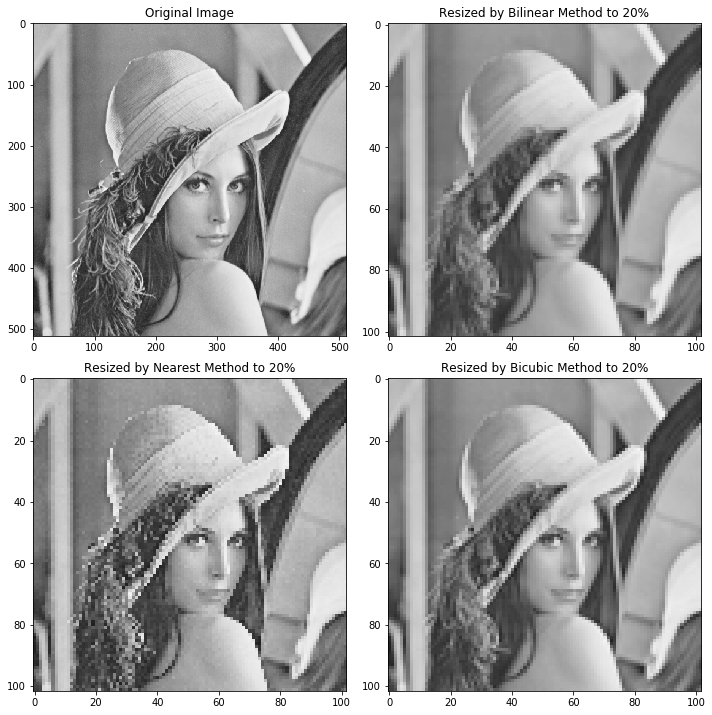

In [13]:
#Import the lena image to resize
img_path = './images/'
img_name = 'lena-grey.bmp'
lena_im = io.imread(img_path.__add__(img_name))

#Perform image required image resizing on the lena image
resized_lena_bilinear = img_resize(lena_im, 20, 'bilinear')
resized_lena_nearest = img_resize(lena_im, 20, 'nearest')
resized_lena_bicubic = img_resize(lena_im, 20, 'bicubic')

#Plot the images together to compare
fig = plt.figure(figsize=(10, 10))

plt.subplot(221)
io.imshow(lena_im, cmap = cm.Greys_r)
plt.title("Original Image")

plt.subplot(222)
io.imshow(resized_lena_bilinear, cmap = cm.Greys_r)
plt.title("Resized by Bilinear Method to 20%")

plt.subplot(223)
io.imshow(resized_lena_nearest, cmap = cm.Greys_r)
plt.title("Resized by Nearest Method to 20%")

plt.subplot(224)
io.imshow(resized_lena_bicubic, cmap = cm.Greys_r)
plt.title("Resized by Bicubic Method to 20%");

**Q.2 Write three functions that performs `simple_blend`, `alpha_blend` and `pyramid_blend`**

** Using your functions, blend `orange` and `apple` images together.**


In [80]:
def simple_blend (image1, image2):
    if (np.shape(image1) != np.shape(image2)):
        print("Image mismatch: images are different sizes")
    blended_image = np.zeros_like(image1)
    im1_height, im1_width, im1_depth = np.shape(image1)
    im2_height, im2_width, im2_depth = np.shape(image2)
    image1 = image1[:,:int(im1_width/2)]
    image2 = image2[:,int(im1_width/2):]
    for i in range (0,im1_height):
        for j in range (0,int(im1_width/2)):
            blended_image[i,j] = image1[i,j]
        for j in range (int(im1_width/2),im1_width):
            blended_image[i,j] = image2[i,j-int(im1_width/2)]
    return(blended_image)

def alpha_blend (image1, image2, window, alpha):
    if (np.shape(image1) != np.shape(image2)):
        print("Image mismatch: images are different sizes")
    im1_height, im1_width, im1_depth = np.shape(image1)
    im2_height, im2_width, im2_depth = np.shape(image2)
    blended_image = np.zeros_like(image1)
    blending_window = alpha * image1 + (1-alpha) * image2
    image1 = image1[:,:int(im1_width/2)-int(window/2)]
    image2 = image2[:,int(im1_width/2)+int(window/2):]
    for i in range (0,im1_height):
        for j in range (0,int(im1_width/2)-int(window/2)):
            blended_image[i,j] = image1[i,j]
        for j in range (int(im1_width/2)-int(window/2),int(im1_width/2+int(window/2))):
            blended_image[i,j] = blending_window[i,j]
        for j in range (int(im1_width/2+int(window/2)),im1_width):
            blended_image[i,j] = image2[i,j-int(im1_width/2)-int(window/2)]
    return(blended_image)

def pyramid_blend (image1, image2):
    return(blended_image)

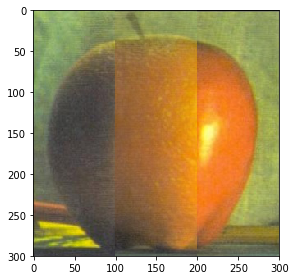

In [83]:
img_name = 'orange.jpeg'
orange = io.imread(img_path.__add__(img_name))
img_name = 'apple.jpeg'
apple = io.imread(img_path.__add__(img_name))


blended_im = simple_blend(orange,apple)
new_blend = alpha_blend(orange, apple, 100, 0.5)
io.imshow(new_blend)
